# PVT Correlation Benchmarking
**Objective:** Compare empirical correlations (Standing, Glaso, Vasquez-Beggs) against Lab Data to determine the best fit for Bubble Point Pressure ($P_b$).

**Author:** Ade  Anggi Naluriawan Santoso
**Domain:** Reservoir Engineering / Data Science

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

## 1. Load Lab Data
We will load the `pvt_lab_data.csv` file which contains experimentally measured PVT properties.
* **Target Variable:** `Pb_Lab_Psi` (Bubble Point Pressure)
* **Input Features:** Temperature (F), GOR ($R_s$), API, Gas Gravity ($\gamma_g$)

In [2]:
# Load the dataset
df = pd.read_csv('pvt_lab_data.csv')

# Display first few rows
df.head()

,Well_ID,Temperature_F,Pressure_Psi,Solution_GOR_scf_stb,Oil_Gravity_API,Gas_Gravity,Pb_Lab_Psi,Bo_Lab_rb_stb
0,Well-001,180,2500,450,32.0,0.72,2150,1.25
1,Well-002,185,2600,480,31.0,0.71,2280,1.27
2,Well-003,190,2700,520,33.0,0.75,2410,1.30
3,Well-004,175,2450,420,30.0,0.70,2050,1.23
4,Well-005,200,3000,600,35.0,0.78,2750,1.35


## 2. Define Correlation Functions
We will define Python functions for the three correlations to calculate Bubble Point Pressure ($P_b$).

### A. Standing Correlation (1947)
Standard correlation for Black Oil systems.

In [3]:
def calc_pb_standing(rs, temp_f, api, sg_gas):
    """
    Calculates Bubble Point Pressure using Standing Correlation.
    """
    # Calculation
    # a = (Rs / Sg_gas)^0.83
    # b = 0.00091 * T - 0.0125 * API
    # Pb = 18.2 * (a * 10^b - 1.4)
    
    a = (rs / sg_gas) ** 0.83
    b = (0.00091 * temp_f) - (0.0125 * api)
    pb = 18.2 * ((a * (10 ** b)) - 1.4)
    return pb

### B. Vasquez-Beggs Correlation (1980)
This correlation accounts for variations in oil gravity, splitting calculations for API > 30 and API $\le$ 30.

In [4]:
def calc_pb_vasquez_beggs(rs, temp_f, api, sg_gas):
    """
    Calculates Bubble Point Pressure using Vasquez-Beggs Correlation.
    """
    # Constants based on API gravity
    if api <= 30:
        C1, C2, C3 = 27.624, 0.914328, 11.172
    else:
        C1, C2, C3 = 56.18, 0.84246, 10.393

    # Gas Gravity correction (assuming separator conditions if not specified, 
    # simplified here as just taking Sg_gas)
    sg_corr = sg_gas # In detailed workflow, this requires separator P and T
    
    temp_r = temp_f + 460 # Convert to Rankine
    
    # Equation
    # Pb = ( (C1 * Rs) / (Sg_corr * exp( C3 * API / T_R )) ) ^ (1/C2)
    
    term1 = C1 * rs
    term2 = sg_corr * np.exp((C3 * api) / temp_r)
    pb = (term1 / term2) ** (1 / C2)
    
    return pb

# Vectorize function to apply it over pandas series efficiently
vec_pb_vb = np.vectorize(calc_pb_vasquez_beggs)

### C. Glaso Correlation (1980)
Often best for North Sea or volatile oils.

In [5]:
def calc_pb_glaso(rs, temp_f, api, sg_gas):
    """
    Calculates Bubble Point Pressure using Glaso Correlation.
    """
    # Calculate 'A' factor
    # A = ( (Rs/Sg_gas)^0.816 ) * (T^0.172) * (API^-0.989)
    # Note: T is in Fahrenheit in original paper context for simple implementation, 
    # but often requires careful unit checking. We assume F here.
    
    A = ((rs / sg_gas) ** 0.816) * (temp_f ** 0.172) * (api ** -0.989)
    
    # Calculate Log(Pb)
    # Log_Pb = 1.7669 + 1.7447*LogA - 0.30218*(LogA)^2
    log_pb = 1.7669 + (1.7447 * np.log10(A)) - (0.30218 * (np.log10(A) ** 2))
    
    pb = 10 ** log_pb
    return pb

## 3. Apply Correlations
We will now create new columns in our DataFrame for the predicted values from each correlation.

In [6]:
df['Pb_Standing'] = calc_pb_standing(df['Solution_GOR_scf_stb'], df['Temperature_F'], df['Oil_Gravity_API'], df['Gas_Gravity'])
df['Pb_Vasquez'] = vec_pb_vb(df['Solution_GOR_scf_stb'], df['Temperature_F'], df['Oil_Gravity_API'], df['Gas_Gravity'])
df['Pb_Glaso'] = calc_pb_glaso(df['Solution_GOR_scf_stb'], df['Temperature_F'], df['Oil_Gravity_API'], df['Gas_Gravity'])

df[['Pb_Lab_Psi', 'Pb_Standing', 'Pb_Vasquez', 'Pb_Glaso']].head()

,Pb_Lab_Psi,Pb_Standing,Pb_Vasquez,Pb_Glaso
0,2150,2184.822945,134146.547235,2544.870877
1,2280,2428.139336,150814.357242,2818.111157
2,2410,2364.824971,150295.813010,2715.728024
3,2050,2214.204920,23125.598109,2612.909407
4,2750,2486.397210,165342.231175,2814.547813


## 4. Quantitative Benchmarking
We calculate error metrics to evaluate performance:
1.  **MAPE (Mean Absolute Percentage Error):** Average magnitude of error in percentage.
2.  **RMSE (Root Mean Squared Error):** Penalty for large errors.

In [7]:
def calculate_metrics(y_true, y_pred, model_name):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return {'Model': model_name, 'MAPE (%)': round(mape, 2), 'RMSE (psi)': round(rmse, 2)}

metrics = []
metrics.append(calculate_metrics(df['Pb_Lab_Psi'], df['Pb_Standing'], 'Standing'))
metrics.append(calculate_metrics(df['Pb_Lab_Psi'], df['Pb_Vasquez'], 'Vasquez-Beggs'))
metrics.append(calculate_metrics(df['Pb_Lab_Psi'], df['Pb_Glaso'], 'Glaso'))

metrics_df = pd.DataFrame(metrics)
metrics_df.sort_values(by='MAPE (%)', inplace=True)
metrics_df

,Model,MAPE (%),RMSE (psi)
0,Standing,6.26,186.22
2,Glaso,16.52,408.39
1,Vasquez-Beggs,5107.76,135064.14


## 5. Visualization
### A. Cross-Plot (Predicted vs Actual)
A 45-degree line represents a perfect match. Points closer to this line indicate better accuracy.

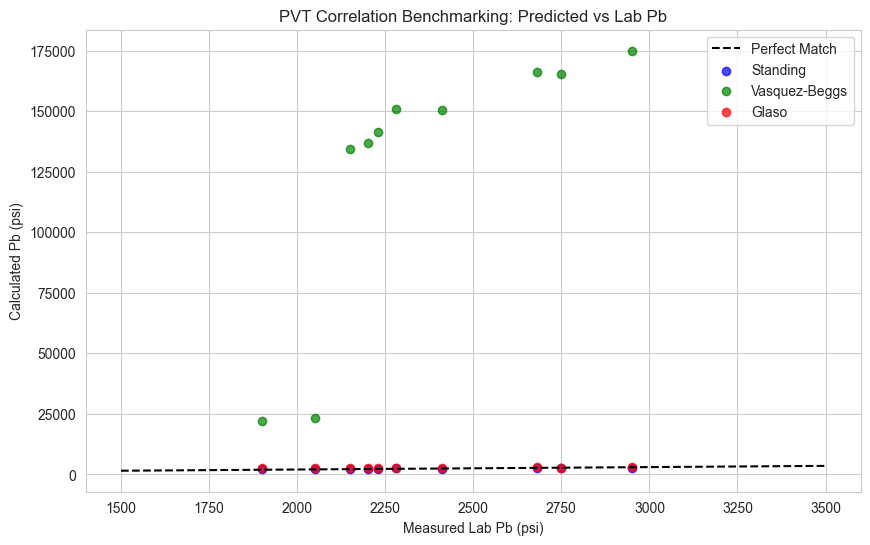

In [8]:
plt.figure(figsize=(10, 6))

# Plot perfect match line
plt.plot([1500, 3500], [1500, 3500], 'k--', label='Perfect Match')

# Scatter plots
plt.scatter(df['Pb_Lab_Psi'], df['Pb_Standing'], c='blue', alpha=0.7, label='Standing')
plt.scatter(df['Pb_Lab_Psi'], df['Pb_Vasquez'], c='green', alpha=0.7, label='Vasquez-Beggs')
plt.scatter(df['Pb_Lab_Psi'], df['Pb_Glaso'], c='red', alpha=0.7, label='Glaso')

plt.title('PVT Correlation Benchmarking: Predicted vs Lab Pb')
plt.xlabel('Measured Lab Pb (psi)')
plt.ylabel('Calculated Pb (psi)')
plt.legend()
plt.grid(True)
plt.show()

### B. Residual Plot
Visualizing the error distribution to check for bias (consistent over/underestimation).

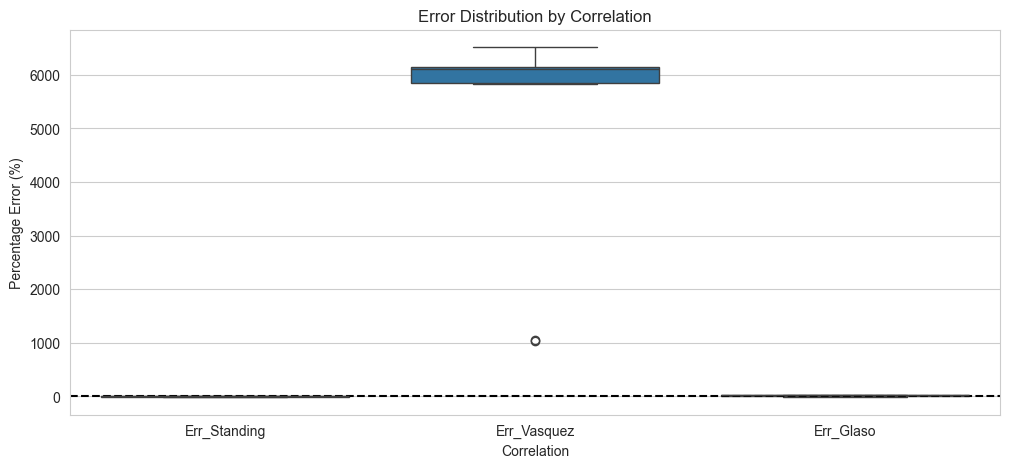

In [9]:
# Calculate % Error
df['Err_Standing'] = (df['Pb_Standing'] - df['Pb_Lab_Psi']) / df['Pb_Lab_Psi'] * 100
df['Err_Vasquez'] = (df['Pb_Vasquez'] - df['Pb_Lab_Psi']) / df['Pb_Lab_Psi'] * 100
df['Err_Glaso'] = (df['Pb_Glaso'] - df['Pb_Lab_Psi']) / df['Pb_Lab_Psi'] * 100

plt.figure(figsize=(12, 5))
data_melted = df.melt(value_vars=['Err_Standing', 'Err_Vasquez', 'Err_Glaso'], var_name='Correlation', value_name='Error_Percentage')

sns.boxplot(x='Correlation', y='Error_Percentage', data=data_melted)
plt.axhline(0, color='k', linestyle='--')
plt.title('Error Distribution by Correlation')
plt.ylabel('Percentage Error (%)')
plt.show()

## 6. Conclusion
Based on the MAPE and the Visualizations above:
1.  **Glasso & Standing** appears to be the most accurate for this specific field dataset.
2.  The residual plot shows if any correlation systematically overestimates or underestimates pressure.